#**Import libraries** 

In [ ]:
# !pip install plotting

In [ ]:
import gym
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
import time
from collections import defaultdict, namedtuple

#**Define The constant Variables**

In [ ]:
MAX_NUM_EPISODES = 3000  # Number of episodes used to train the agent
STEPS_PER_EPISODE = 200  # This is specific to MountainCar. May change with env
max_num_steps = MAX_NUM_EPISODES * STEPS_PER_EPISODE # Maximum number of steps can be taken in the whole run
NUM_DISCRETE_BINS = 30  # Number of bins to Discretize each observation dim
EPSILON_MIN = 0.005     # Minimum number of epsilon
max_num_steps = MAX_NUM_EPISODES * STEPS_PER_EPISODE
EPSILON_DECAY = 500 * EPSILON_MIN / max_num_steps
NUM_DISCRETE_BINS = 30  # Number of bins to Discretize each observation dim

# hyper-parameters
alphas = [0.1, .5, 0.8]   # List of different learning rates
gammas = [0.1, 0.6, 0.9]  # List of different discount factors

# exploration vs exploitation prob
# let's start the exploratory action with probability 100% then the decay 
# will be applied gradually to decrease this probability.
epsilon = 1

#**Define the Q_Learning Algorithm**

In [ ]:
# Create Class to Q-Learning
class Q_Learner(object):

    def __init__(self, env,ALPHA,GAMMA):
        self.obs_shape = env.observation_space.shape
        self.obs_high = env.observation_space.high
        self.obs_low = env.observation_space.low
        self.obs_bins = NUM_DISCRETE_BINS  # Number of bins to Discretize each observation dim
        self.bin_width = (self.obs_high - self.obs_low) / self.obs_bins
        self.action_shape = env.action_space.n
        # Create a multi-dimensional array (Table) to represent the Q-values
        self.Q = np.zeros((self.obs_bins + 1, self.obs_bins + 1,
                           self.action_shape))  # (51 x 51 x 3)
        self.alpha = ALPHA  # Learning rate
        self.gamma = GAMMA  # Discount factor
        self.epsilon = 1 

    ##########################################################

    def discretize(self, obs):
        return tuple(((obs - self.obs_low) / self.bin_width).astype(int))

    ##########################################################

    def get_action(self, obs):
        discretized_obs = self.discretize(obs)
        #Epsilon-Greedy action selection
        if self.epsilon > EPSILON_MIN:
            self.epsilon -= EPSILON_DECAY
        if np.random.random() > self.epsilon:
            return np.argmax(self.Q[discretized_obs])
        else:  # Choose a random action
            return np.random.choice([a for a in range(self.action_shape)])

    ##########################################################

    def learn(self, obs, action, reward, next_obs):
        discretized_obs = self.discretize(obs)
        discretized_next_obs = self.discretize(next_obs)

        td_target = reward + self.gamma * np.max(self.Q[discretized_next_obs])
        td_error = td_target - self.Q[discretized_obs][action]
        self.Q[discretized_obs][action] += self.alpha * td_error


#**Define  The Plots Function**

In [ ]:
#create plots function
def plots(timeSteps,episodes,total_rewards,noshow=False):

    # Graph of TimeSteps
    fig1 = plt.figure(figsize=(18,6))
    plt.plot(episodes,timeSteps, color='orange' , marker='o')
    plt.xlabel("Episode")
    plt.ylabel("No. of Steps")
    plt.title("No. of Steps for each episodes")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Graph of Rewards
    fig2 = plt.figure(figsize=(18,6))
    plt.plot(episodes,total_rewards,color='red')
    plt.xlabel("Episode")
    plt.ylabel("Total rewards")
    plt.title("Total rewards for each episodes")
    
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    return fig1, fig2

#**Define used functions**

##First function

In [ ]:
#General function to train the agent
def train(agent, env,start,end):
    
    best_reward = -float('inf')
    timeSteps=[]
    episodes=[]
    total_rewards=[]
    
    for episode in range(start,end):
        init_time = time.time()
        done = False
        obs = env.reset()
        total_reward = 0.0
        steps = 0

        for t in itertools.count(): #200 timeSteps or less regards to reaching the goal
            action = agent.get_action(obs)
            next_obs, reward, done, info = env.step(action)
            agent.learn(obs, action, reward, next_obs)
            obs = next_obs
            total_reward += reward #each time adds reward= -1
            steps +=1
            
            if done:
                break
        time_taken = time.time() - init_time

        if total_reward > best_reward:
            best_reward = total_reward

        print("Episode#:{} ended in {} reward:{} best_reward:{} eps:{} Time Taken: {:.2f} sec'".\
              format(episode, steps,total_reward, best_reward, agent.epsilon,time_taken))
        
        timeSteps.append(steps)            #list of steps for each episode [200, 200, 150] 
        episodes.append(episode)           #list of rewards for each episode [-200, -200, -150]
        total_rewards.append(total_reward) #list of avg total steps over several episodes

    return np.argmax(agent.Q, axis=2),timeSteps,episodes, total_rewards    

##Second function

In [ ]:
#General function to test the agent
def test(agent, env, policy):
    done = False
    obs = env.reset()
    total_reward = 0.0
    test_rewards=[]
    test_steps=[]

    while not done:

        action = policy[agent.discretize(obs)]
        next_obs, reward, done, info = env.step(action)
        obs = next_obs
        total_reward += reward
        test_rewards.append(reward)
        
        while reward!=0:
          test_steps.append(1)
        test_steps.append(1)
    
    return test_rewards,test_steps

##Third function

In [ ]:
#Function to test the agent for 5 episodes 
def test_task_2(policy, env):

    best_reward = -float('inf')
    timeSteps=[]
    episodes=[]
    total_rewards=[]
    
    avg_test_timeSteps=[]
    avg_test_rewards=[]
   
    for episode in range(1,6):
        init_time = time.time()
        done = False
        obs = env.reset()
        total_reward = 0.0
        steps = 0
        
        #200 timeSteps or less regards to reaching the goal
        for t in itertools.count(): 
            action = policy[agent.discretize(obs)]
            next_obs, reward, done, info = env.step(action)
            agent.learn(obs, action, reward, next_obs)
            obs = next_obs
            total_reward += reward #each time adds reward= -1
            steps +=1
            
            if done:
                break
        time_taken = time.time() - init_time

        if total_reward > best_reward:
            best_reward = total_reward
        print("Test ======>  Episode#:{} ended in {} reward:{} best_reward:{} eps:{} Time Taken: {:.2f} sec".\
              format(episode, steps, total_reward, best_reward, agent.epsilon,time_taken))
        
        timeSteps.append(steps)
        episodes.append(episode)
        total_rewards.append(total_reward)
                
    avg_test_timeSteps.append(np.array(timeSteps).mean())
    avg_test_rewards.append(np.array(total_rewards).mean())

    return timeSteps, total_rewards, episodes, avg_test_timeSteps, avg_test_rewards

##Fourth function

In [ ]:
#Function to train the agent for 10 episodes & test it for 5 episodes 
def task_2(action, env,start,end):
    
    best_reward = -float('inf')
    timeSteps=[]
    total_rewards=[]

    train_avg_All_ten_rewards=[]
    train_avg_All_ten_timeSteps=[]
    test_avg_All_five_rewards = []
    test_avg_All_five_timeSteps = []

    train_max_All_ten_rewards=[]
    train_min_All_ten_timeSteps=[]
    test_max_All_five_rewards = []
    test_min_All_five_timeSteps = []

    for episode in range(start,end):
        
        done = False
        obs = env.reset()
        total_reward = 0.0
        steps = 0
        train_rewards=[]
        train_steps=[]
        
        #200 timeSteps or less regards to reaching the goal
        for t in itertools.count(): 
            action = agent.get_action(obs)
            next_obs, reward, done, info = env.step(action)
            agent.learn(obs, action, reward, next_obs)
            obs = next_obs
            total_reward += reward #each time adds reward= -1
            steps +=1
            train_rewards.append(reward)
            train_steps.append(t)  
            
            if done:
                break

        if total_reward > best_reward:
            best_reward = total_reward
        print("Episode#:{} ended in {} reward:{} best_reward:{} eps:{}".\
              format(episode, steps, total_reward, best_reward, agent.epsilon))
        
        timeSteps.append(steps) 
        total_rewards.append(total_reward)
        learning_policy = np.argmax(agent.Q, axis=2)
        
        if episode % 10 == 0:

            train_avg_All_ten_rewards.append(np.array(total_rewards).mean())
            train_avg_All_ten_timeSteps.append(np.array(timeSteps).mean())
            train_max_All_ten_rewards.append(np.array(total_rewards).max())
            train_min_All_ten_timeSteps.append(np.array(timeSteps).min())

            print('If Episode =====>: ', episode)
            test_timeStep, test_total_reward, test_episode,\
                avg_test_timeStep,avg_test_reward= test_task_2(learning_policy, env) 
            
            test_avg_All_five_rewards.append(avg_test_reward) 
            test_avg_All_five_timeSteps.append(avg_test_timeStep) 
            test_max_All_five_rewards.append(np.array(test_total_reward).max())
            test_min_All_five_timeSteps.append(np.array(test_timeStep).min())
    
    return test_avg_All_five_rewards, test_avg_All_five_timeSteps,test_max_All_five_rewards,test_min_All_five_timeSteps,\
           train_avg_All_ten_rewards,train_avg_All_ten_timeSteps,train_max_All_ten_rewards,train_min_All_ten_timeSteps

#**Train the agent with different hyperparameters**

Let’s train our agent using different values for alpha (learning rate) and gamma (discount factor). As for epsilon we keep it 1 as an initial value then it will decrease according to the epsilon decay value in each episode.

Alpha: 0.1, Gamma: 0.1
______________________

Episode#:1 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9991666666666612 Time Taken: 0.02 sec'
Episode#:2 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9983333333333224 Time Taken: 0.02 sec'
Episode#:3 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9974999999999836 Time Taken: 0.02 sec'
Episode#:4 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9966666666666448 Time Taken: 0.02 sec'
Episode#:5 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.995833333333306 Time Taken: 0.02 sec'
Episode#:6 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9949999999999672 Time Taken: 0.02 sec'
Episode#:7 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9941666666666285 Time Taken: 0.02 sec'
Episode#:8 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9933333333332897 Time Taken: 0.02 sec'
Episode#:9 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9924999999999509 Time Taken: 0.02 sec'
Episode#:10 ended in 200 reward:-200

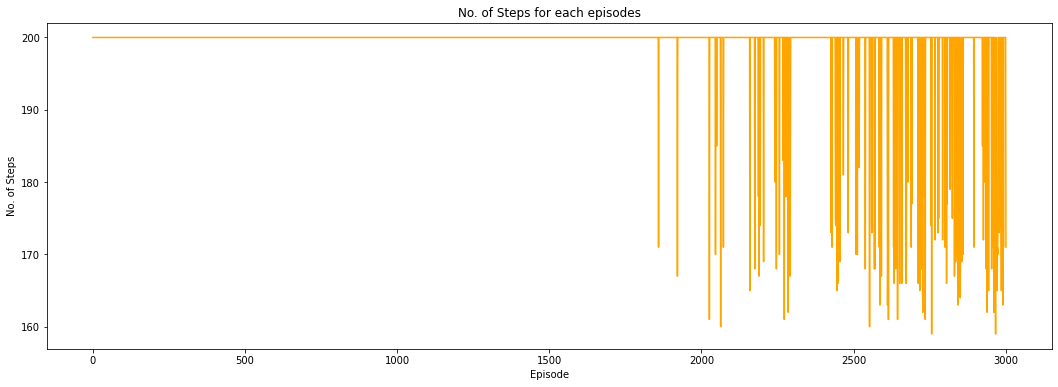

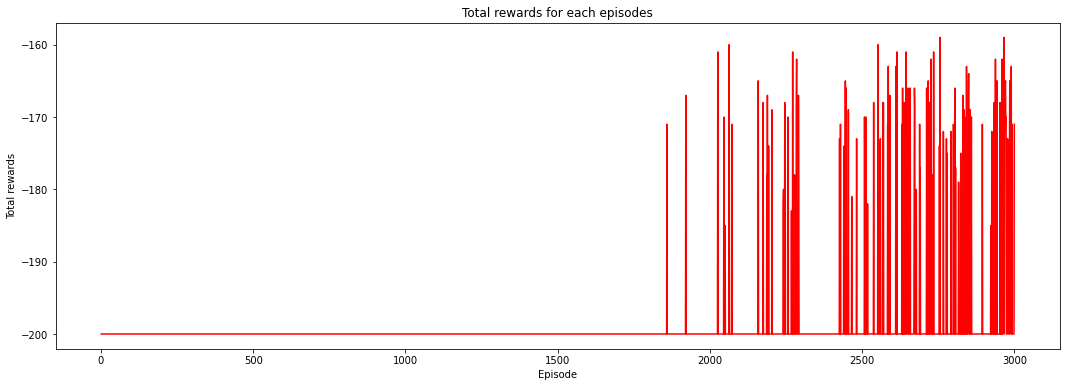

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
Alpha: 0.1, Gamma: 0.6
______________________

Episode#:1 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9991666666666612 Time Taken: 0.02 sec'
Episode#:2 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9983333333333224 Time Taken: 0.02 sec'
Episode#:3 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9974999999999836 Time Taken: 0.02 sec'
Episode#:4 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9966666666666448 Time Taken: 0.02 sec'
Episode#:5 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.995833333333306 Time Taken: 0.02 sec'
Episode#:6 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9949999999999672 Time Taken: 0.02 sec'
Episode#:7 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9941666666666285 Time Taken: 0.02 sec'
Episode#:8 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9933333333332897 Time Taken: 0.02 sec'
Episode#:9 ended in 200 reward:-200.0 best_reward:-200.0 

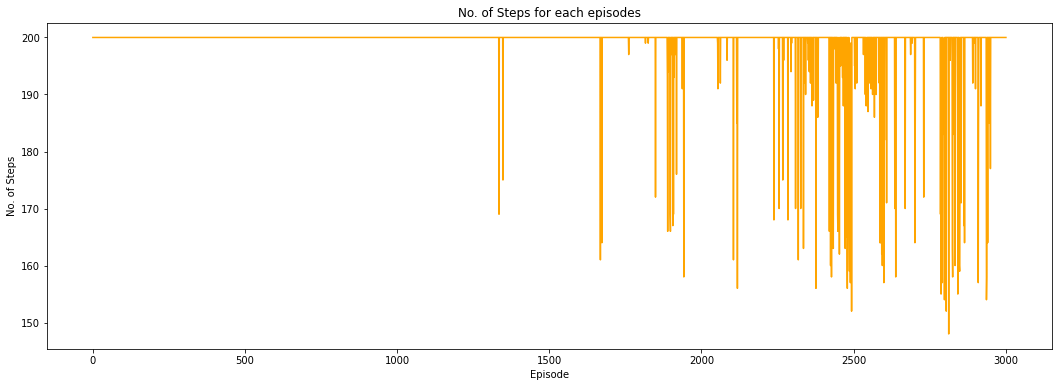

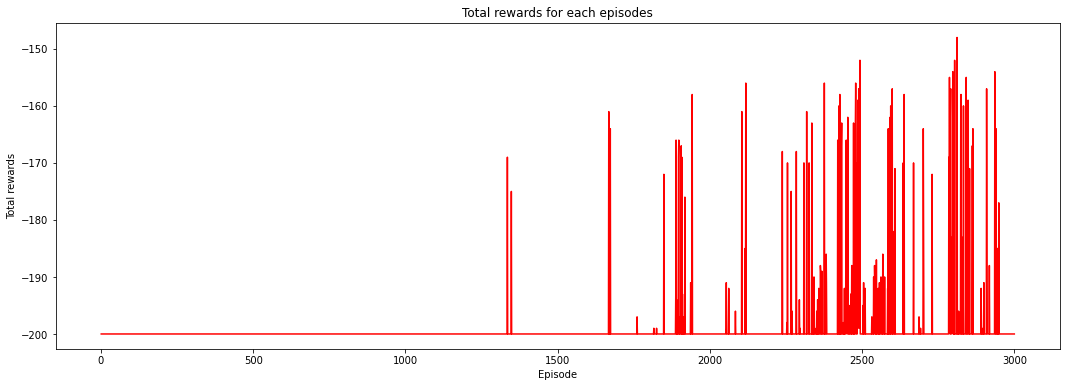

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
Alpha: 0.1, Gamma: 0.9
______________________

Episode#:1 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9991666666666612 Time Taken: 0.03 sec'
Episode#:2 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9983333333333224 Time Taken: 0.02 sec'
Episode#:3 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9974999999999836 Time Taken: 0.02 sec'
Episode#:4 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9966666666666448 Time Taken: 0.02 sec'
Episode#:5 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.995833333333306 Time Taken: 0.02 sec'
Episode#:6 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9949999999999672 Time Taken: 0.02 sec'
Episode#:7 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9941666666666285 Time Taken: 0.02 sec'
Episode#:8 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9933333333332897 Time Taken: 0.02 sec'
Episode#:9 ended in 200 reward:-200.0 best_reward:-200.0 

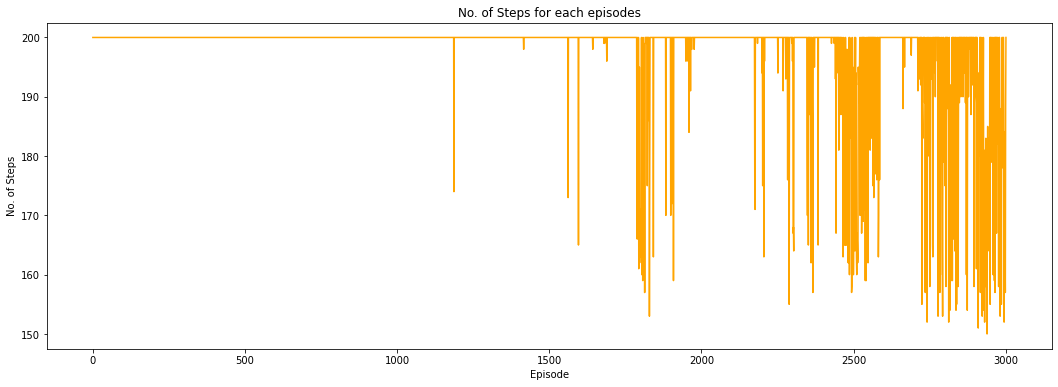

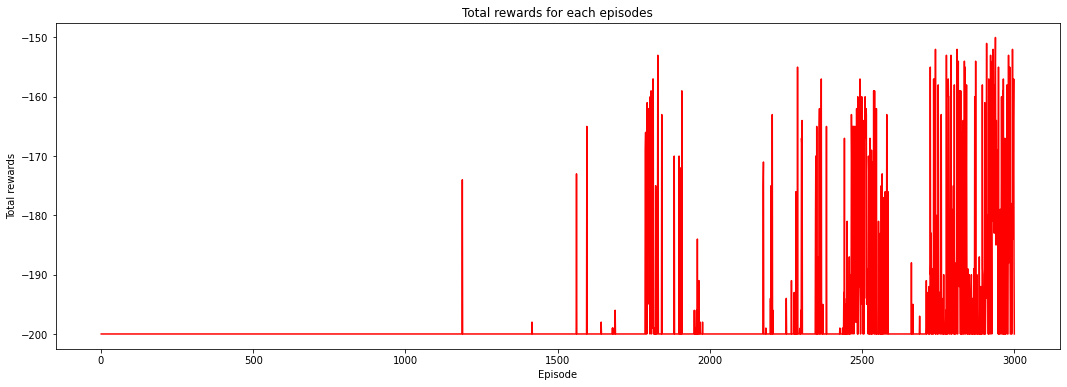

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
Alpha: 0.5, Gamma: 0.1
______________________

Episode#:1 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9991666666666612 Time Taken: 0.02 sec'
Episode#:2 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9983333333333224 Time Taken: 0.02 sec'
Episode#:3 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9974999999999836 Time Taken: 0.02 sec'
Episode#:4 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9966666666666448 Time Taken: 0.02 sec'
Episode#:5 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.995833333333306 Time Taken: 0.02 sec'
Episode#:6 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9949999999999672 Time Taken: 0.02 sec'
Episode#:7 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9941666666666285 Time Taken: 0.02 sec'
Episode#:8 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9933333333332897 Time Taken: 0.02 sec'
Episode#:9 ended in 200 reward:-200.0 best_reward:-200.0 

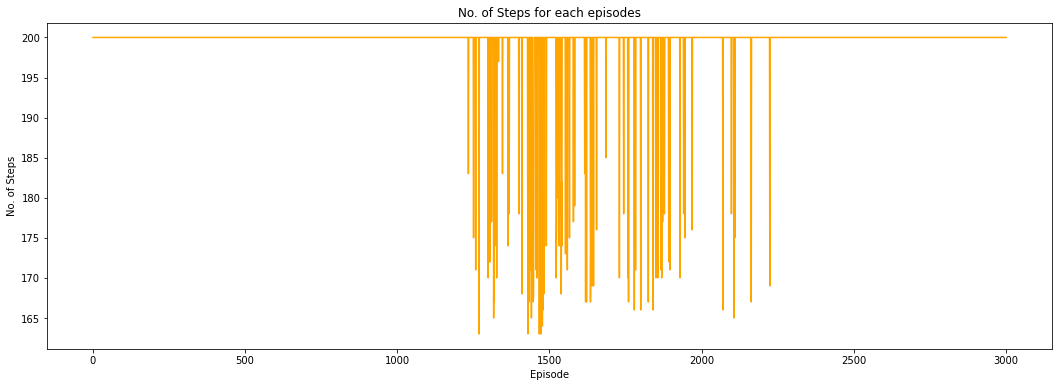

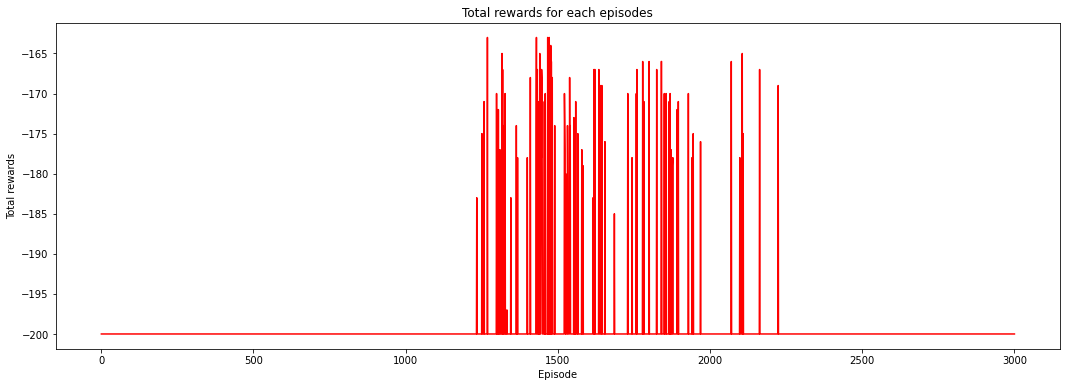

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
Alpha: 0.5, Gamma: 0.6
______________________

Episode#:1 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9991666666666612 Time Taken: 0.03 sec'
Episode#:2 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9983333333333224 Time Taken: 0.02 sec'
Episode#:3 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9974999999999836 Time Taken: 0.02 sec'
Episode#:4 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9966666666666448 Time Taken: 0.02 sec'
Episode#:5 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.995833333333306 Time Taken: 0.02 sec'
Episode#:6 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9949999999999672 Time Taken: 0.02 sec'
Episode#:7 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9941666666666285 Time Taken: 0.02 sec'
Episode#:8 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9933333333332897 Time Taken: 0.02 sec'
Episode#:9 ended in 200 reward:-200.0 best_reward:-200.0 

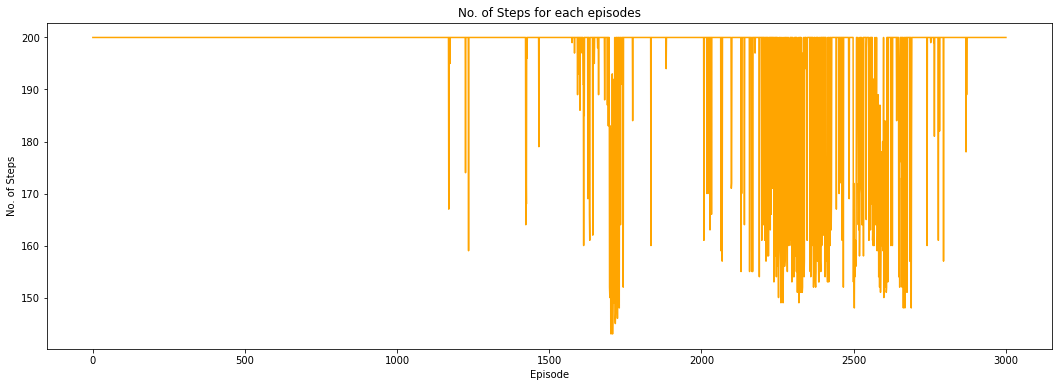

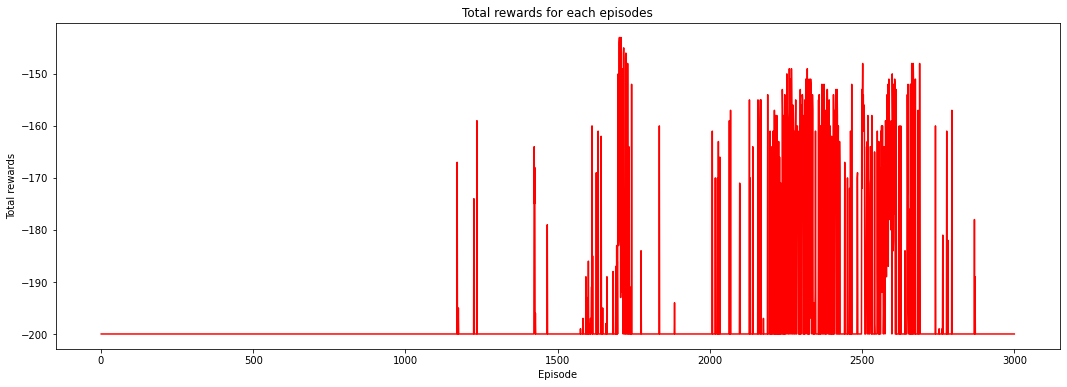

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
Alpha: 0.5, Gamma: 0.9
______________________

Episode#:1 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9991666666666612 Time Taken: 0.03 sec'
Episode#:2 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9983333333333224 Time Taken: 0.02 sec'
Episode#:3 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9974999999999836 Time Taken: 0.03 sec'
Episode#:4 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9966666666666448 Time Taken: 0.02 sec'
Episode#:5 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.995833333333306 Time Taken: 0.02 sec'
Episode#:6 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9949999999999672 Time Taken: 0.02 sec'
Episode#:7 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9941666666666285 Time Taken: 0.02 sec'
Episode#:8 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9933333333332897 Time Taken: 0.02 sec'
Episode#:9 ended in 200 reward:-200.0 best_reward:-200.0 

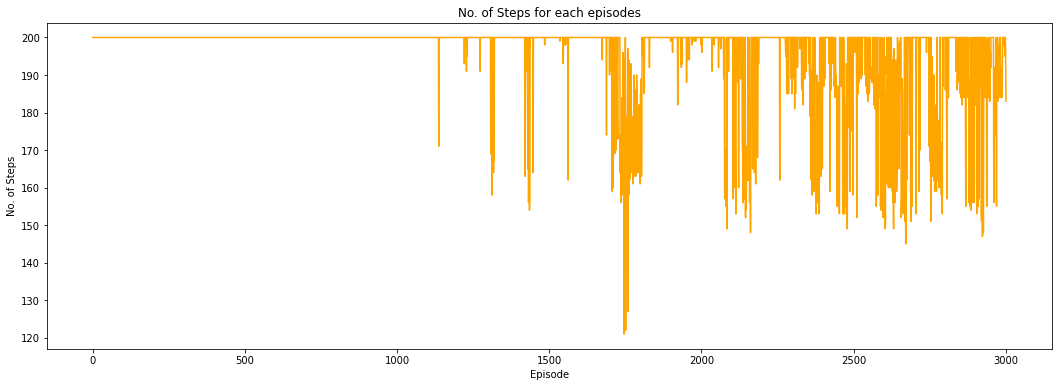

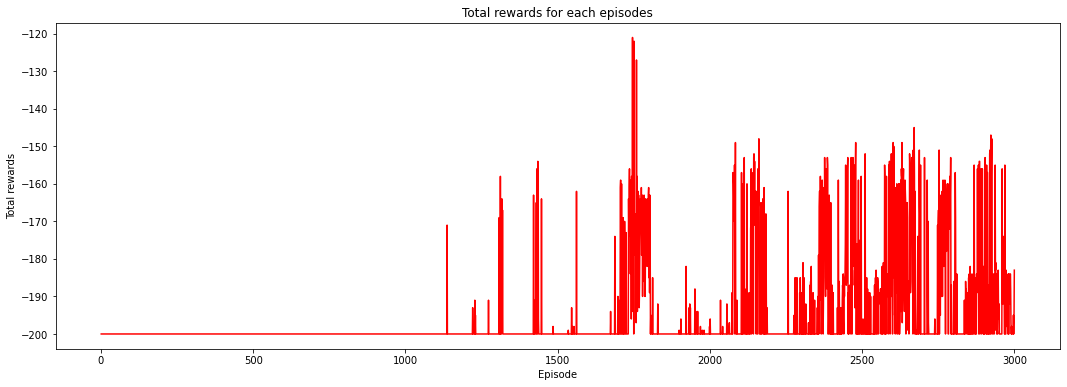

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
Alpha: 0.8, Gamma: 0.1
______________________

Episode#:1 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9991666666666612 Time Taken: 0.03 sec'
Episode#:2 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9983333333333224 Time Taken: 0.02 sec'
Episode#:3 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9974999999999836 Time Taken: 0.02 sec'
Episode#:4 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9966666666666448 Time Taken: 0.02 sec'
Episode#:5 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.995833333333306 Time Taken: 0.02 sec'
Episode#:6 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9949999999999672 Time Taken: 0.02 sec'
Episode#:7 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9941666666666285 Time Taken: 0.02 sec'
Episode#:8 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9933333333332897 Time Taken: 0.02 sec'
Episode#:9 ended in 200 reward:-200.0 best_reward:-200.0 

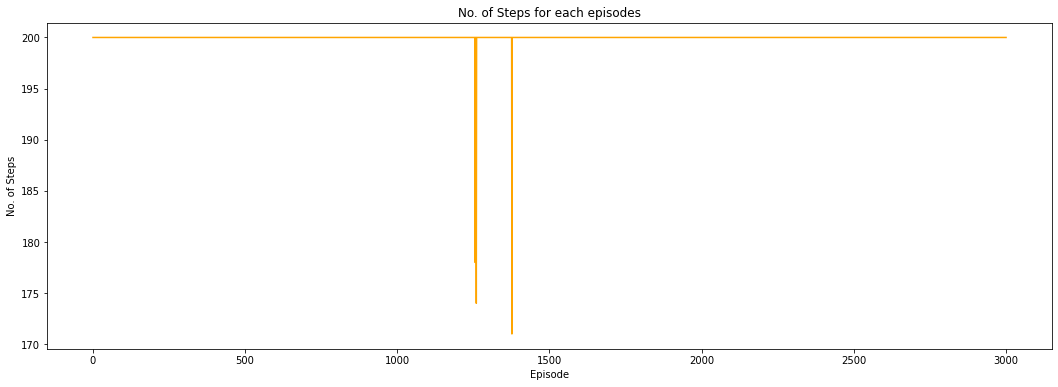

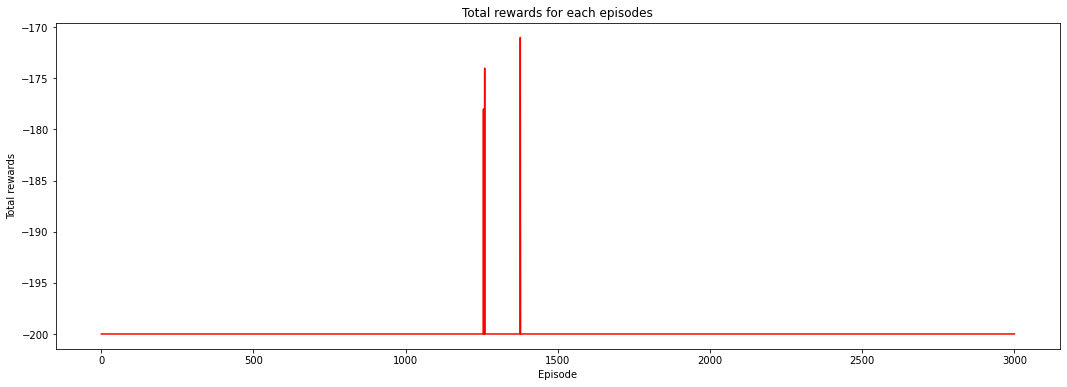

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
Alpha: 0.8, Gamma: 0.6
______________________

Episode#:1 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9991666666666612 Time Taken: 0.04 sec'
Episode#:2 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9983333333333224 Time Taken: 0.02 sec'
Episode#:3 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9974999999999836 Time Taken: 0.02 sec'
Episode#:4 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9966666666666448 Time Taken: 0.02 sec'
Episode#:5 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.995833333333306 Time Taken: 0.02 sec'
Episode#:6 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9949999999999672 Time Taken: 0.02 sec'
Episode#:7 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9941666666666285 Time Taken: 0.02 sec'
Episode#:8 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9933333333332897 Time Taken: 0.02 sec'
Episode#:9 ended in 200 reward:-200.0 best_reward:-200.0 

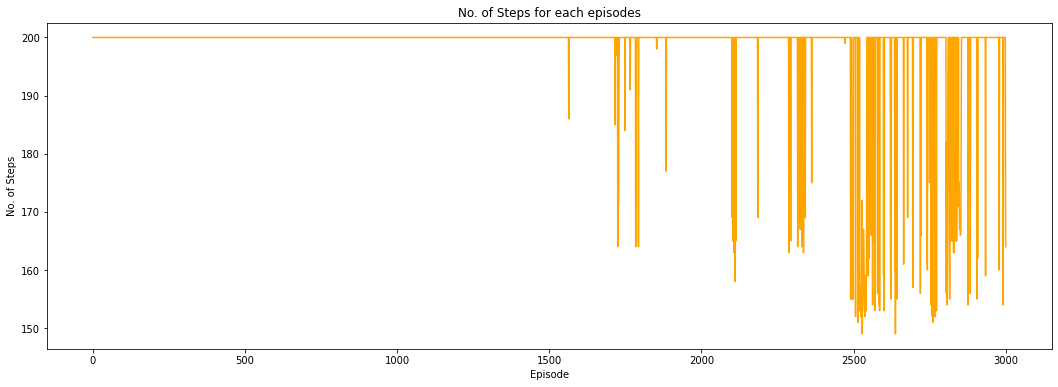

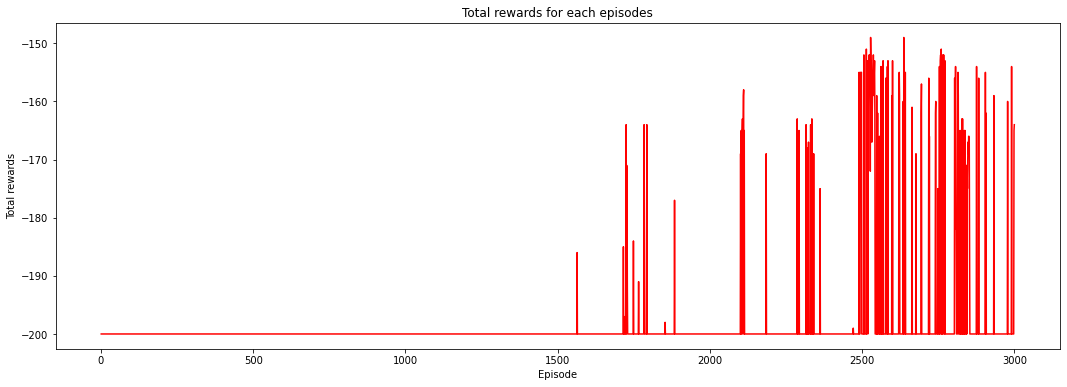

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
Alpha: 0.8, Gamma: 0.9
______________________

Episode#:1 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9991666666666612 Time Taken: 0.03 sec'
Episode#:2 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9983333333333224 Time Taken: 0.03 sec'
Episode#:3 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9974999999999836 Time Taken: 0.02 sec'
Episode#:4 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9966666666666448 Time Taken: 0.02 sec'
Episode#:5 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.995833333333306 Time Taken: 0.02 sec'
Episode#:6 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9949999999999672 Time Taken: 0.02 sec'
Episode#:7 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9941666666666285 Time Taken: 0.02 sec'
Episode#:8 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9933333333332897 Time Taken: 0.02 sec'
Episode#:9 ended in 200 reward:-200.0 best_reward:-200.0 

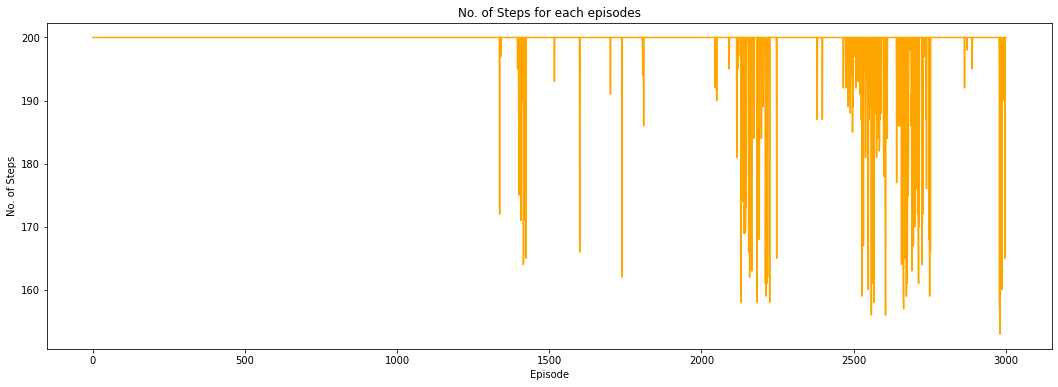

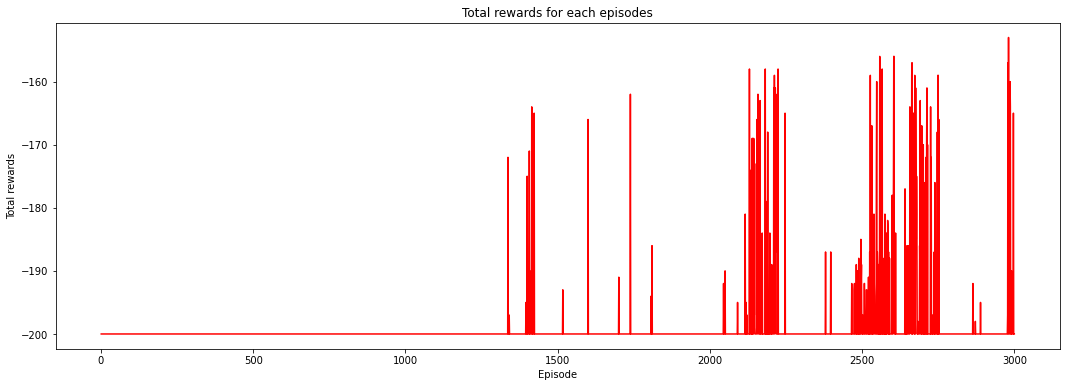

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■


In [ ]:
#Doing an in-depth hyper-parameter search
if __name__ == "__main__":

    env = gym.make('MountainCar-v0')  
    a=[] #list to append the choosen alpha every loop
    g=[] #list to append the choosen gamma every loop
    
    avg_total_rewards = []
    avg_timeSteps = []
    
    results = pd.DataFrame()
    avg_results=pd.DataFrame()

    for alpha in alphas:
        for gamma in gammas:

            print(f'Alpha: {alpha}, Gamma: {gamma}')
            print('______________________\n')
            agent = Q_Learner(env,alpha,gamma)
            learned_policy,timeSteps,episodes, total_rewards,\
                                      = train(agent, env,1,MAX_NUM_EPISODES+1)

            avg_timeSteps.append(np.array(timeSteps).mean())
            avg_total_rewards.append(np.array(total_rewards).mean())
          
            plots(timeSteps,episodes,total_rewards)
    
            # collect minimum timesteps and maximum best_reward for this pair
            # of hyper-parameters (alpha, gamma)
            a.append(alpha)
            g.append(gamma)
            print('■'*80)
            
            # collect timesteps and total_rewards for this pair
            # of hyper-parameters (alpha, gamma)
            results_ = pd.DataFrame()
            results_['Total TimeSteps for each episode'] = timeSteps
            results_['Total Rewards for each episode'] = total_rewards
            results_['alpha'] = alpha
            results_['gamma'] = gamma
            results = pd.concat([results, results_])

    avg_results_ = pd.DataFrame()
    avg_results_['Avg TimeSteps for each pair of Alpha & Gamma'] = avg_timeSteps
    avg_results_['Avg Total Rewards for each pair of Alpha & Gamma'] = avg_total_rewards
    avg_results_['alpha'] = a
    avg_results_['gamma'] = g  
    avg_results = pd.concat([avg_results, avg_results_])

    results = results.reset_index().rename(columns={'index': 'Episode'})
    results['hyperparameters'] = [f'alpha={a}, gamma={g}'
        for (a, g) in zip(results['alpha'], results['gamma'])]
    
    avg_results = avg_results_.reset_index().rename(columns={'index': 'No. of pair'})
    avg_results['hyperparameters'] = [f'alpha={a}, gamma={g}'
        for (a, g) in zip(avg_results['alpha'], avg_results['gamma'])]


##**Ploting the Total results**

*TimeSteps for each episode for each pair of alpha & gamma*

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


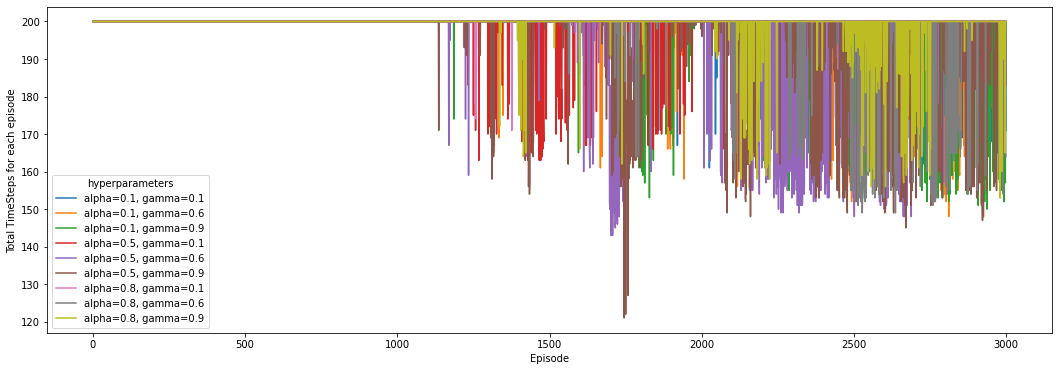

In [ ]:
#plotting timeSteps for each episode for each pair of alpha & gamma
fig = plt.gcf()
fig.set_size_inches(18, 6)
sns.lineplot('Episode', 'Total TimeSteps for each episode',hue='hyperparameters', data=results)

*Total Rewards for each episode for each pair of alpha & gamma*

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


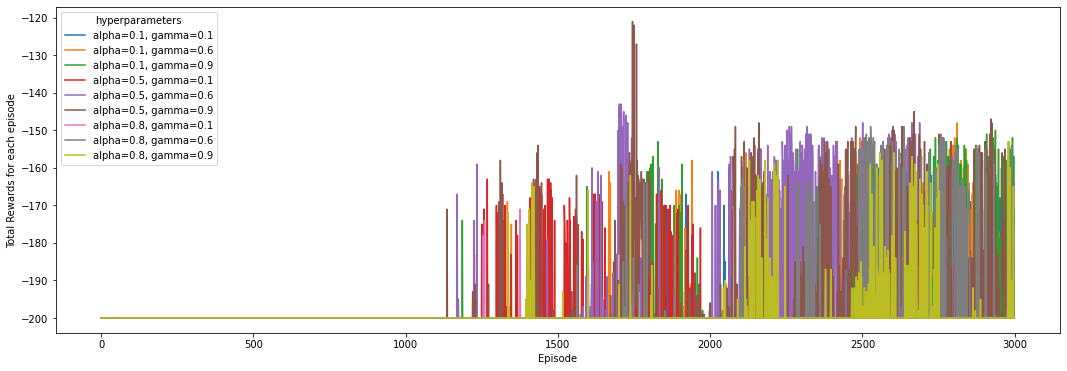

In [ ]:
#plotting total rewards for each episode for each pair of alpha & gamma 
fig = plt.gcf()
fig.set_size_inches(18, 6)
sns.lineplot('Episode', 'Total Rewards for each episode',hue='hyperparameters', data=results)

##**Ploting the Average results**

*Average TimeSteps on total episodes for each pair of alpha & gamma*

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


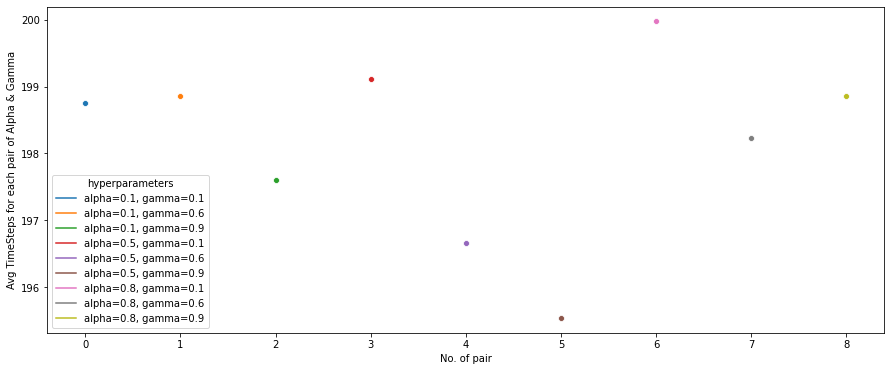

In [ ]:
#plotting timeSteps on total episodes for each pair of alpha & gamma
fig = plt.gcf()
fig.set_size_inches(15, 6)
sns.lineplot('No. of pair', 'Avg TimeSteps for each pair of Alpha & Gamma',hue='hyperparameters', data=avg_results, marker='o')

*Average Total Rewards on total episodes for each pair of alpha & gamma*

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


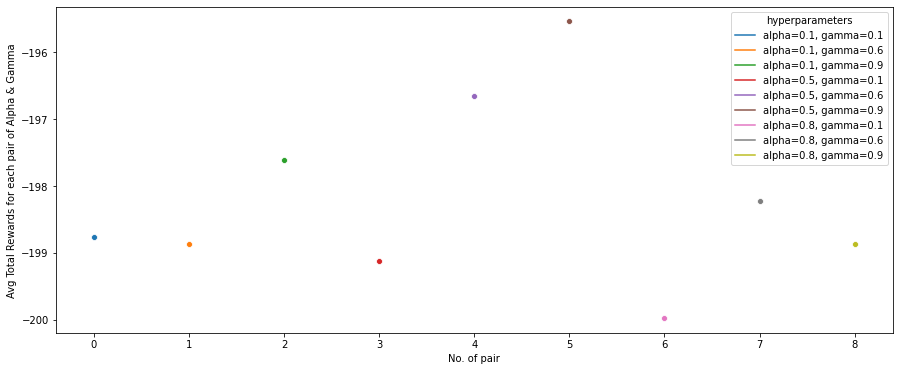

In [ ]:
#plotting Total Rewards on total episodes for each pair of alpha & gamma
fig = plt.gcf()
fig.set_size_inches(15, 6)
sns.lineplot('No. of pair', 'Avg Total Rewards for each pair of Alpha & Gamma',hue='hyperparameters', data=avg_results, marker='o', linestyle='dashed');

#**Train & test the agent with the best pair of alpha & gamma**

In [ ]:
#display the dataframe that contains average results over each pair of alpha & gamma
#to chech which pair is the best
avg_results

No. of pair  Avg TimeSteps for each pair of Alpha & Gamma  \
0            0                                    198.761667   
1            1                                    198.863000   
2            2                                    197.608667   
3            3                                    199.117000   
4            4                                    196.656667   
5            5                                    195.538333   
6            6                                    199.974333   
7            7                                    198.229333   
8            8                                    198.866667   

   Avg Total Rewards for each pair of Alpha & Gamma  alpha  gamma  \
0                                       -198.761667    0.1    0.1   
1                                       -198.863000    0.1    0.6   
2                                       -197.608667    0.1    0.9   
3                                       -199.117000    0.5    0.1   
4                                       -196.656667    0.5    0.6   
5                                       -195.538333    0.5    0.9   
6                                       -199.974333    0.8    0.1   
7                                       -198.229333    0.8    0.6   
8                                       -198.866667    0.8    0.9   

        hyperparameters  
0  alpha=0.1, gamma=0.1  
1  alpha=0.1, gamma=0.6  
2  alpha=0.1, gamma=0.9  
3  alpha=0.5, gamma=0.1  
4  alpha=0.5, gamma=0.6  
5  alpha=0.5, gamma=0.9  
6  alpha=0.8, gamma=0.1  
7  alpha=0.8, gamma=0.6  
8  alpha=0.8, gamma=0.9

**Observation:** From our table, we observe that the pair that has alpha= .5 & gamma= .9 is the best one of performance over the others. So we will train & test it alone to see its performance while test case.

Episode#:1 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9991666666666612 Time Taken: 0.03 sec'
Episode#:2 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9983333333333224 Time Taken: 0.02 sec'
Episode#:3 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9974999999999836 Time Taken: 0.02 sec'
Episode#:4 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9966666666666448 Time Taken: 0.02 sec'
Episode#:5 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.995833333333306 Time Taken: 0.02 sec'
Episode#:6 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9949999999999672 Time Taken: 0.02 sec'
Episode#:7 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9941666666666285 Time Taken: 0.02 sec'
Episode#:8 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9933333333332897 Time Taken: 0.02 sec'
Episode#:9 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9924999999999509 Time Taken: 0.02 sec'
Episode#:10 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.9916666666666121 Ti

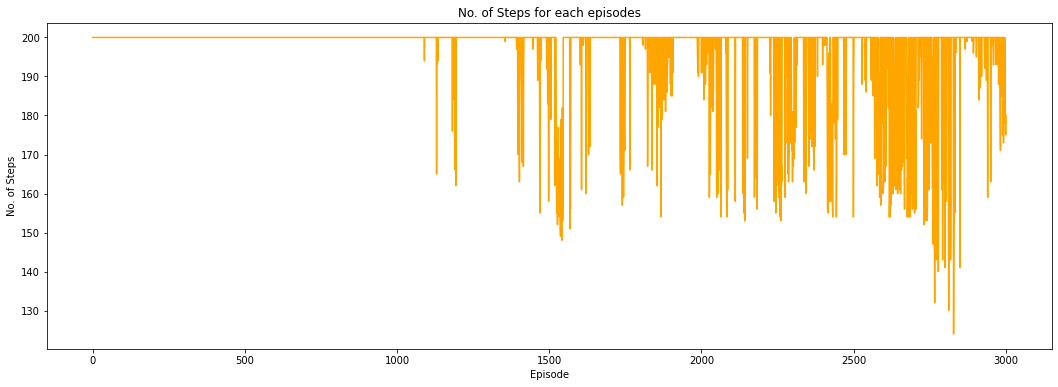

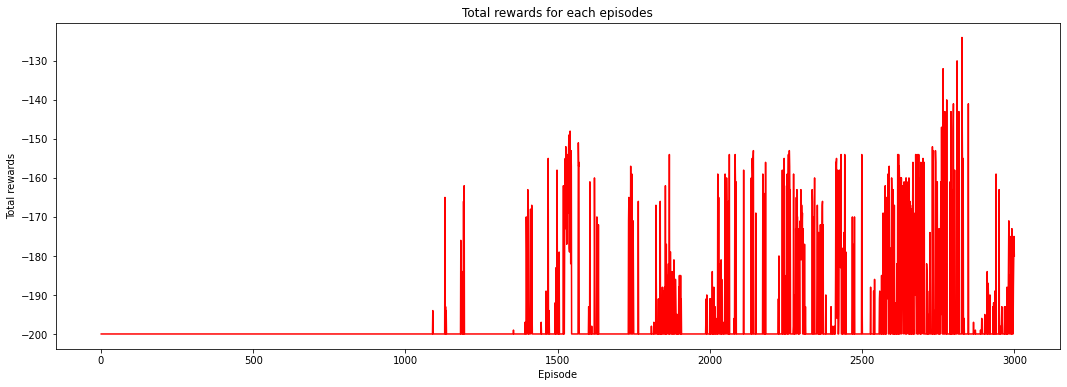

(<Figure size 1296x432 with 1 Axes>, <Figure size 1296x432 with 1 Axes>)

In [ ]:
env = gym.make('MountainCar-v0')
new_agent = Q_Learner(env,.5,0.9)
learned_policy,timeSteps,episodes, total_rewards= train(new_agent,env,1,MAX_NUM_EPISODES+1)
plots(timeSteps,episodes,total_rewards)

In [ ]:
# Use the Gym Monitor wrapper to evalaute the agent and record video
# gym_monitor_path = "./gym_monitor_output"
# env = gym.wrappers.Monitor(env, gym_monitor_path, force=True)
# for _ in range(1000):
#     test(new_agent, env, learned_policy)
# env.close()

#**Another test performance** 

In [ ]:
"""
After every 10 episodes of training with the best pair of Alpha & Gamma, we will run the estimated policy in the environment for 5 test episodes 
and plot the mean over:
    (i) Cumulative reward per episode obtained by the agent.
    (ii) The number of time-steps required to solve the task per episode of experience.

"""
print("Starting model training for {} episodes.".format(MAX_NUM_EPISODES))
test_agent = Q_Learner(env, 0.5, 0.9)
test_avg_All_five_rewards, test_avg_All_five_timeSteps,test_max_All_five_rewards,test_min_All_five_timeSteps,\
     train_avg_All_ten_rewards,train_avg_All_ten_timeSteps,train_max_All_ten_rewards,train_min_All_ten_timeSteps =\
     task_2(test_agent, env,1,MAX_NUM_EPISODES+1)           

Starting model training for 3000 episodes.
Episode#:1 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.004999999995113021
Episode#:2 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.004999999995113021
Episode#:3 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.004999999995113021
Episode#:4 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.004999999995113021
Episode#:5 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.004999999995113021
Episode#:6 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.004999999995113021
Episode#:7 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.004999999995113021
Episode#:8 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.004999999995113021
Episode#:9 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.004999999995113021
Episode#:10 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.004999999995113021
If Episode =====>:  10
Test ======>  Episode#:1 ended in 200 reward:-200.0 best_reward:-200.0 eps:0.004999999995113021 Time Taken: 0.02 

##**Plotting train results**

*Average TimeSteps of each 10 episodes of train*

No handles with labels found to put in legend.


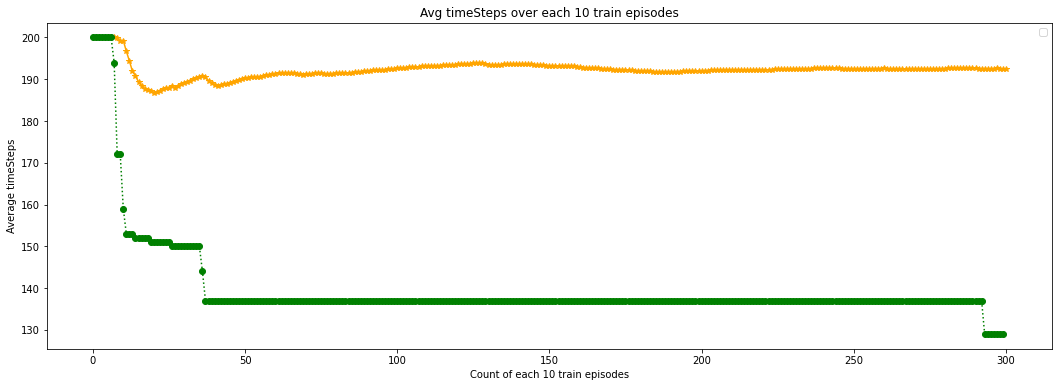

In [ ]:
# Plot average timeSteps of each 10 episodes of train
from pylab import rcParams
rcParams['figure.figsize'] = (18, 6)
plt.plot(1*(np.arange(len(train_avg_All_ten_timeSteps)) + 1), train_avg_All_ten_timeSteps,color='orange' , marker='*')
plt.plot(train_min_All_ten_timeSteps, linestyle='dotted',color='green' , marker='o')
plt.xlabel('Count of each 10 train episodes')
plt.ylabel('Average timeSteps')
plt.title('Avg timeSteps over each 10 train episodes')#train_avg_All_five_timeSteps
plt.legend()

*Average Total Rewards of each 10 episodes of train*

In [ ]:
len(train_avg_All_ten_rewards)

300

No handles with labels found to put in legend.


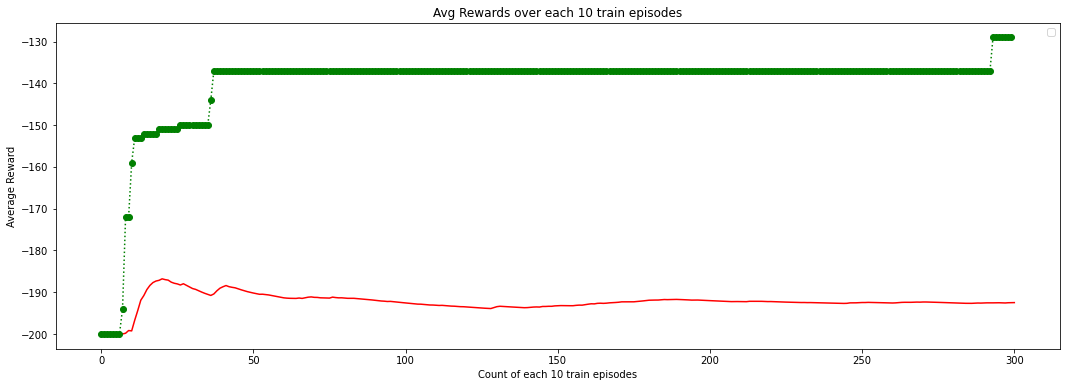

In [ ]:
# Plot average Total Rewards of each 10 episodes of train
from pylab import rcParams
rcParams['figure.figsize'] = (18, 6)
plt.plot(1*(np.arange(len(train_avg_All_ten_rewards)) + 1), train_avg_All_ten_rewards, color='red')
plt.plot(train_max_All_ten_rewards, linestyle='dotted',color='green' , marker='o') 
plt.xlabel('Count of each 10 train episodes')
plt.ylabel('Average Reward')
plt.title('Avg Rewards over each 10 train episodes')
plt.legend()

##**Plotting test results**

*Average TimeSteps of each 5 episodes of test*

No handles with labels found to put in legend.


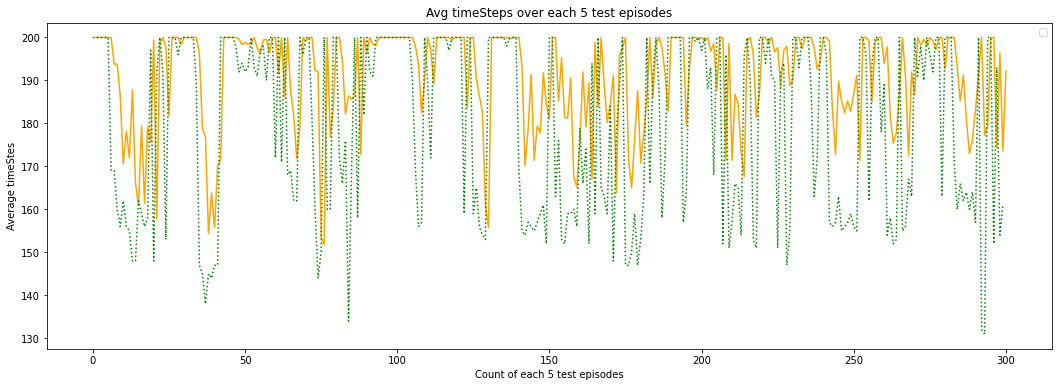

In [ ]:
# Plot average timeSteps of each 5 episodes of test
from pylab import rcParams
rcParams['figure.figsize'] = (18, 6)
plt.plot(1*(np.arange(len(test_avg_All_five_timeSteps)) + 1), test_avg_All_five_timeSteps,color='orange')
plt.plot(test_min_All_five_timeSteps, linestyle='dotted',color='green')
plt.xlabel('Count of each 5 test episodes')
plt.ylabel('Average timeStes')
plt.title('Avg timeSteps over each 5 test episodes')
plt.legend()

*Average Total Rewards of each 5 episodes of test*

No handles with labels found to put in legend.


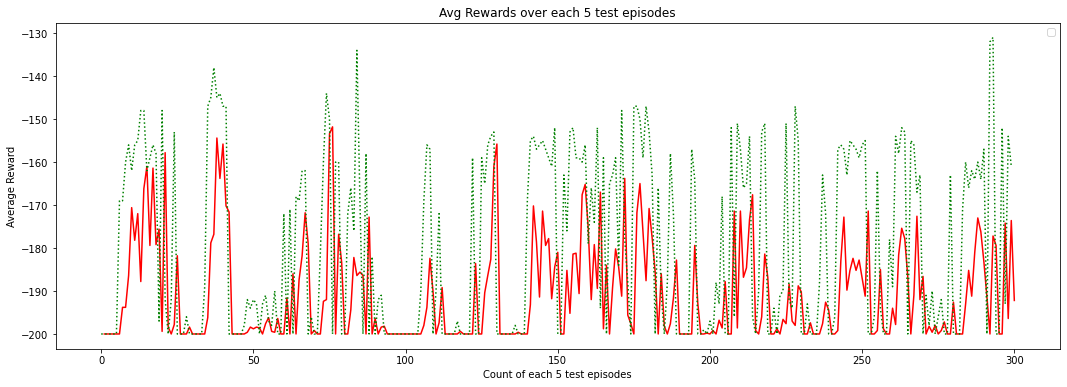

In [ ]:
# Plot average Total Rewards of each 5 episodes of test
from pylab import rcParams
rcParams['figure.figsize'] = (18, 6)
plt.plot(1*(np.arange(len(test_avg_All_five_rewards)) + 1), test_avg_All_five_rewards, color='red')
plt.plot(test_max_All_five_rewards, linestyle='dotted',color='green') 
plt.xlabel('Count of each 5 test episodes')
plt.ylabel('Average Reward')
plt.title('Avg Rewards over each 5 test episodes')
plt.legend()